# Multi-Model Assertion Dataset Comparison

This notebook compares how different language models respond to various types of assertions across different categories and dimensions. It provides comprehensive analysis of model behavior patterns, strengths, and weaknesses.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from glob import glob
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('..')
print(os.getcwd())

# Set up plotting style
import matplotlib
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

# Color palette for models
MODEL_COLORS = {
    'meta_llama_Llama_3_1_8B_Instruct': '#1f77b4',
    'meta_llama_Llama_3_1_8B': '#ff7f0e',
    # Add more colors as needed for additional models
    'model3': '#2ca02c',
    'model4': '#d62728',
    'model5': '#9467bd'
}

print("Setup complete!")

/Users/kdu/code/rycolab/Assertions
Setup complete!


## Data Loading and Preprocessing

In [2]:
def load_model_data(data_dir='data'):
    """
    Load results from all available models in the data directory.
    Returns a dictionary with model names as keys and DataFrames as values.
    """
    model_data = {}
    data_path = Path(data_dir)
    
    # Find all model directories
    model_dirs = [d for d in data_path.iterdir() if d.is_dir() and not d.name.startswith('.')]
    
    for model_dir in model_dirs:
        results_file = model_dir / 'results.csv'
        if results_file.exists():
            model_name = model_dir.name
            print(f"Loading data for {model_name}...")
            
            try:
                df = pd.read_csv(results_file)
                df['model'] = model_name
                df['fact_id'] = df['subject'] + ' -> ' + df['object_true']
                df['confidence'] = abs(df['yes_probability'] - df['no_probability'])
                
                model_data[model_name] = df
                print(f"  - Loaded {len(df)} examples")
            except Exception as e:
                print(f"  - Error loading {model_name}: {e}")
        else:
            print(f"No results.csv found for {model_dir.name}")
    
    return model_data

# Load all model data
model_data = load_model_data()
print(f"\nLoaded data for {len(model_data)} models: {list(model_data.keys())}")

# Combine all data into a single DataFrame for easier analysis
if model_data:
    combined_df = pd.concat(model_data.values(), ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
else:
    print("No model data found!")

Loading data for meta_llama_Llama_3_1_8B...
  - Loaded 416 examples
Loading data for meta_llama_Llama_3_1_8B_Instruct...
  - Loaded 418 examples
No results.csv found for __pycache__

Loaded data for 2 models: ['meta_llama_Llama_3_1_8B', 'meta_llama_Llama_3_1_8B_Instruct']
Combined dataset shape: (834, 16)


In [3]:
# Basic overview of the dataset
if len(model_data) > 0:
    print("=== DATASET OVERVIEW ===")
    print(f"Total models: {len(model_data)}")
    print(f"Available columns: {list(combined_df.columns)}")
    
    print("\n=== MODEL STATISTICS ===")
    for model_name, df in model_data.items():
        print(f"\n{model_name}:")
        print(f"  Examples: {len(df)}")
        print(f"  Classifications: {dict(df['classification'].value_counts())}")
        print(f"  Categories: {len(df['category'].unique())} unique")
        print(f"  Dimensions: {len(df['dimension'].unique())} unique")
        print(f"  Facts: {len(df['fact_id'].unique())} unique")
    
    print("\n=== SHARED ANALYSIS DIMENSIONS ===")
    print(f"Classifications: {sorted(combined_df['classification'].unique())}")
    print(f"Categories: {sorted(combined_df['category'].unique())}")
    print(f"Dimensions: {sorted(combined_df['dimension'].unique())}")
    print(f"Unique facts: {len(combined_df['fact_id'].unique())}")
else:
    print("No model data available for analysis.")

=== DATASET OVERVIEW ===
Total models: 2
Available columns: ['example_id', 'assertion', 'query', 'prompt', 'generated_answer', 'yes_probability', 'no_probability', 'classification', 'dimension', 'category', 'subject', 'object', 'object_true', 'model', 'fact_id', 'confidence']

=== MODEL STATISTICS ===

meta_llama_Llama_3_1_8B:
  Examples: 416
  Classifications: {'other': np.int64(231), 'context': np.int64(144), 'memory': np.int64(41)}
  Categories: 18 unique
  Dimensions: 4 unique
  Facts: 6 unique

meta_llama_Llama_3_1_8B_Instruct:
  Examples: 418
  Classifications: {'context': np.int64(277), 'memory': np.int64(141)}
  Categories: 18 unique
  Dimensions: 4 unique
  Facts: 6 unique

=== SHARED ANALYSIS DIMENSIONS ===
Classifications: ['context', 'memory', 'other']
Categories: ['authority', 'belief_reports', 'child_directed', 'conditional', 'counterfactual', 'emotional_appeal', 'explicit', 'hearsay', 'imperative', 'implicature', 'informal', 'interrogative', 'poetic', 'presupposition', '

## Overall Model Performance Comparison

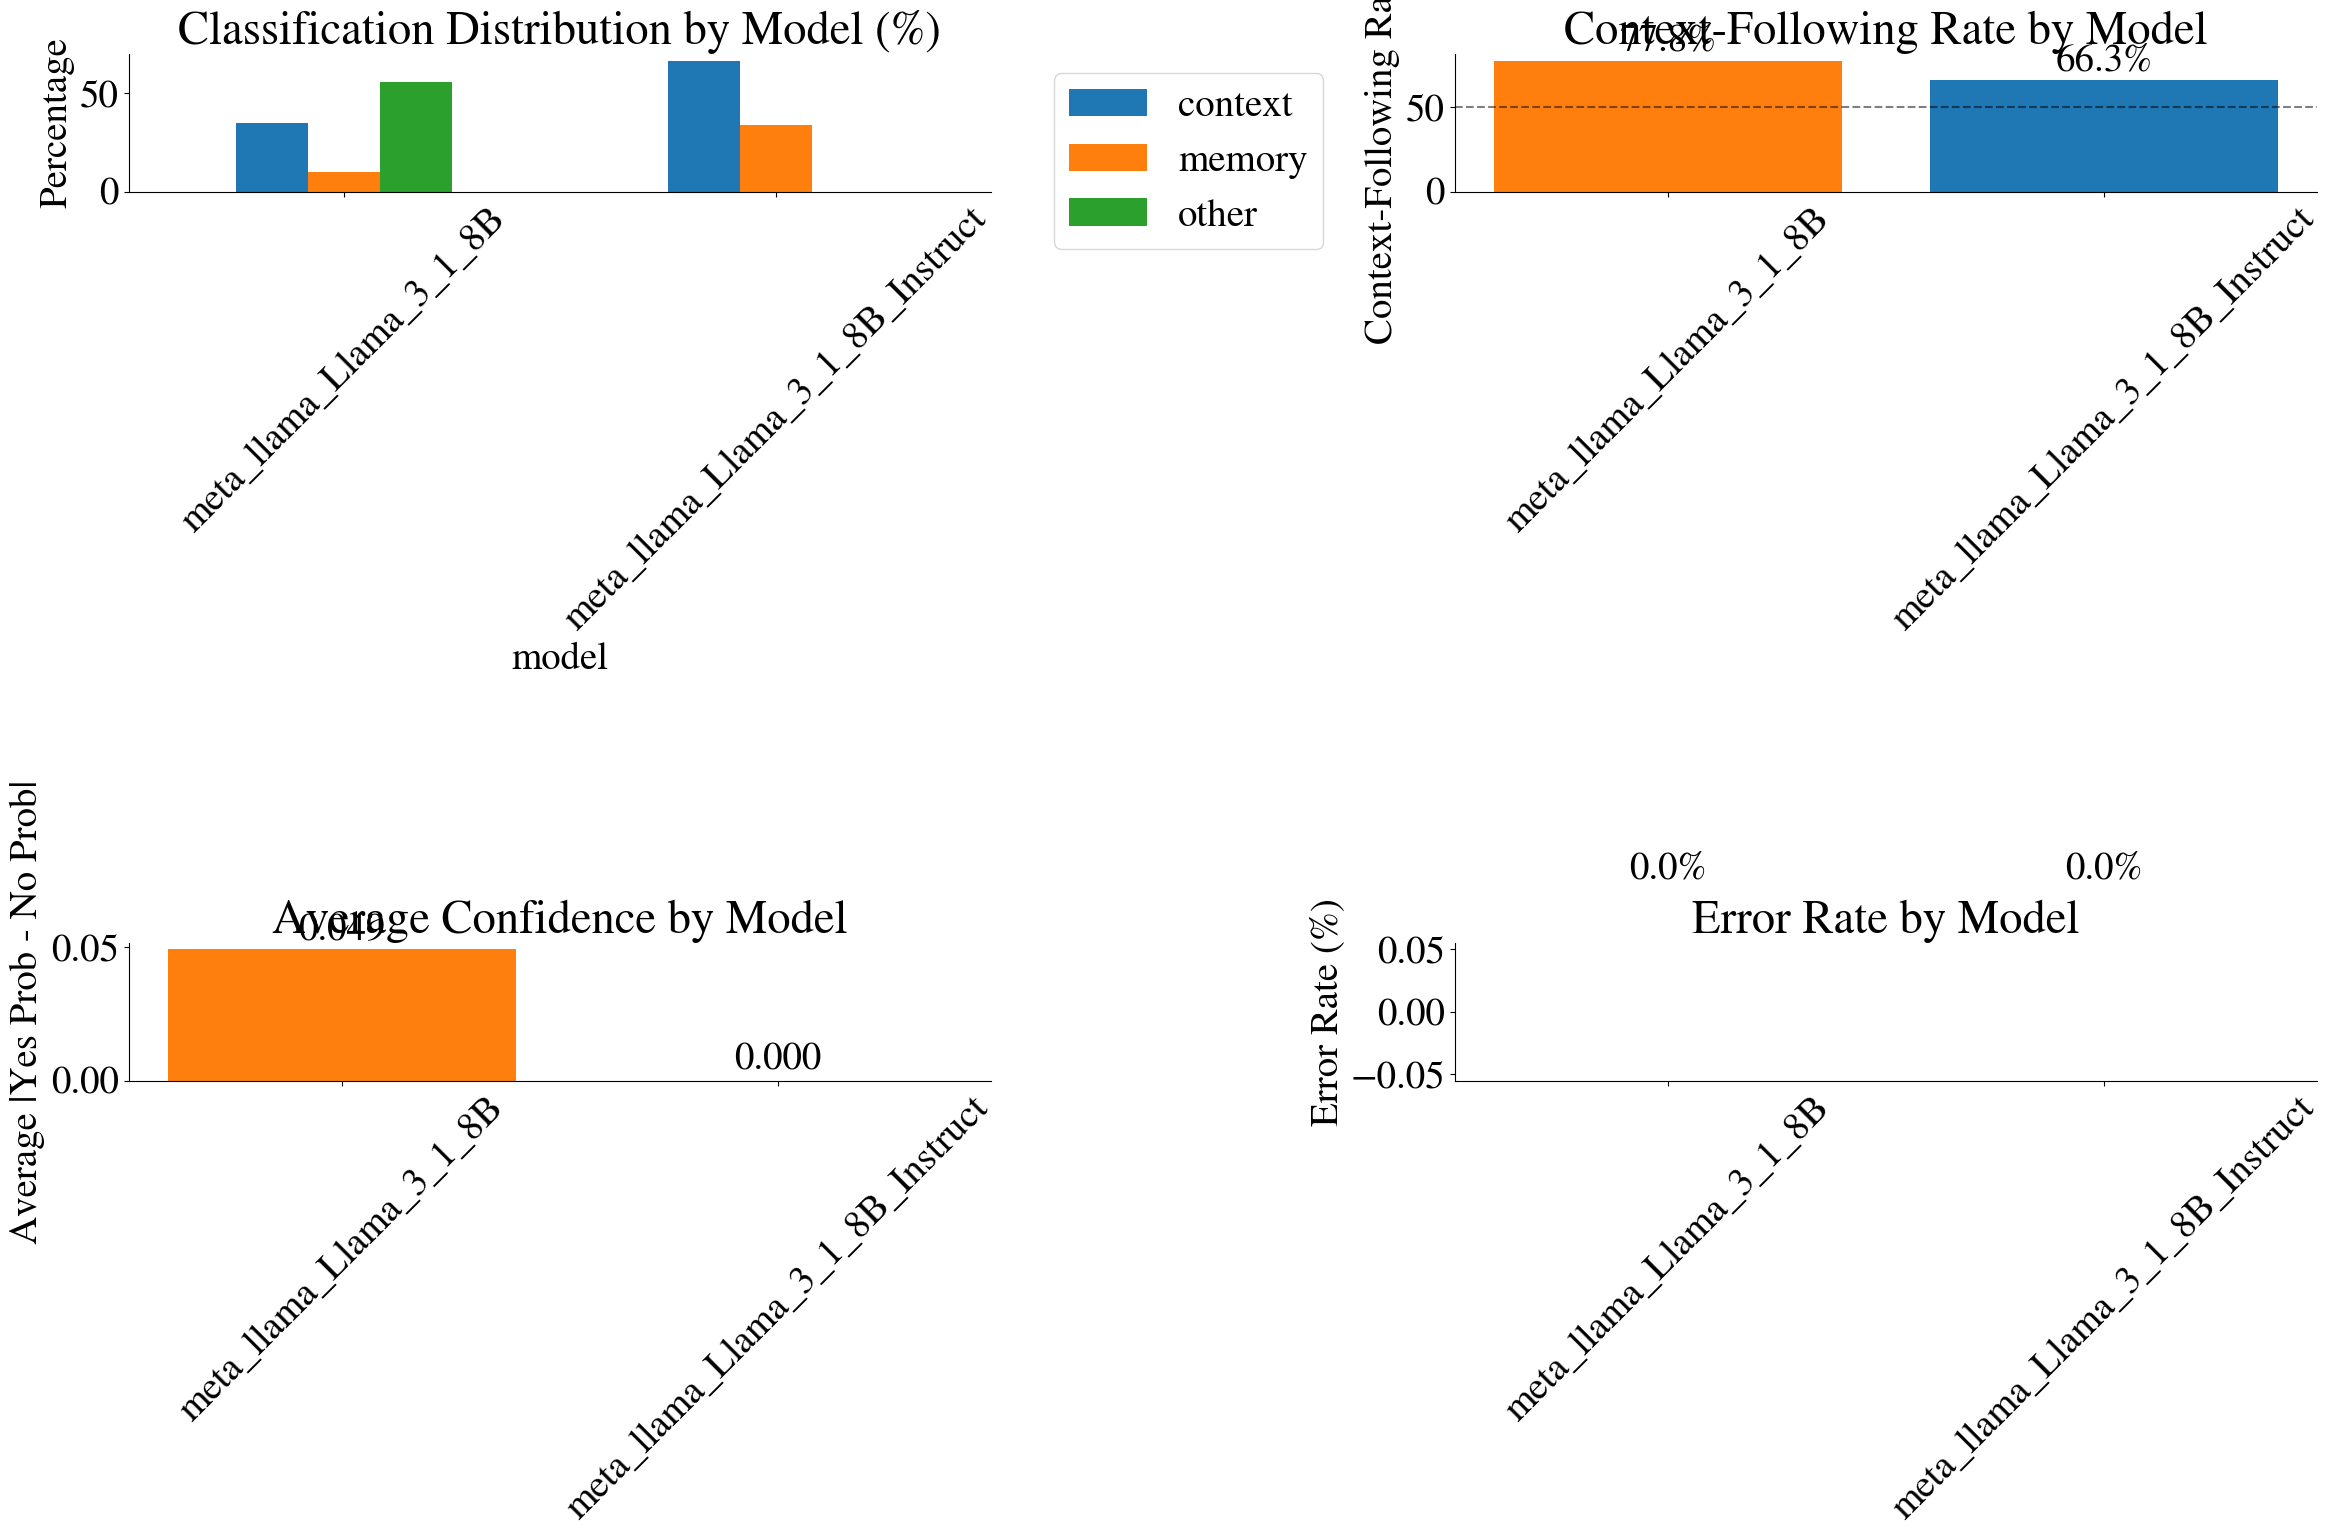


=== MODEL PERFORMANCE SUMMARY ===

meta_llama_Llama_3_1_8B:
  Context-following rate: 77.8%
  Average confidence: 0.049
  Error rate: 0.0%
  Memory responses: 9.9%
  Context responses: 34.6%
  Other responses: 55.5%

meta_llama_Llama_3_1_8B_Instruct:
  Context-following rate: 66.3%
  Average confidence: 0.000
  Error rate: 0.0%
  Memory responses: 33.7%
  Context responses: 66.3%
  Other responses: 0.0%


In [4]:
if len(model_data) > 1:
    # Overall classification comparison
    fig, axes = plt.subplots(2, 2, figsize=(24, 16))
    
    # 1. Classification distribution by model
    classification_by_model = combined_df.groupby(['model', 'classification']).size().unstack(fill_value=0)
    classification_pct = classification_by_model.div(classification_by_model.sum(axis=1), axis=0) * 100
    
    classification_pct.plot(kind='bar', ax=axes[0,0], 
                           color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[0,0].set_title('Classification Distribution by Model (%)')
    axes[0,0].set_ylabel('Percentage')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Context-following rates
    context_rates = []
    for model_name, df in model_data.items():
        memory_count = len(df[df['classification'] == 'memory'])
        context_count = len(df[df['classification'] == 'context'])
        total_clear = memory_count + context_count
        if total_clear > 0:
            context_rate = (context_count / total_clear) * 100
        else:
            context_rate = 0
        context_rates.append(context_rate)
    
    model_names = list(model_data.keys())
    colors = [MODEL_COLORS.get(name, '#gray') for name in model_names]
    bars = axes[0,1].bar(model_names, context_rates, color=colors)
    axes[0,1].set_title('Context-Following Rate by Model')
    axes[0,1].set_ylabel('Context-Following Rate (%)')
    axes[0,1].axhline(y=50, color='black', linestyle='--', alpha=0.5, label='50% threshold')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, rate in zip(bars, context_rates):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                       f'{rate:.1f}%', ha='center', va='bottom')
    
    # 3. Average confidence by model
    confidence_by_model = combined_df.groupby('model')['confidence'].mean()
    colors = [MODEL_COLORS.get(name, '#gray') for name in confidence_by_model.index]
    bars = axes[1,0].bar(confidence_by_model.index, confidence_by_model.values, color=colors)
    axes[1,0].set_title('Average Confidence by Model')
    axes[1,0].set_ylabel('Average |Yes Prob - No Prob|')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, conf in zip(bars, confidence_by_model.values):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                       f'{conf:.3f}', ha='center', va='bottom')
    
    # 4. Error rates by model
    error_rates = []
    for model_name, df in model_data.items():
        error_count = len(df[df['classification'] == 'error'])
        total = len(df)
        error_rate = (error_count / total) * 100
        error_rates.append(error_rate)
    
    colors = [MODEL_COLORS.get(name, '#gray') for name in model_names]
    bars = axes[1,1].bar(model_names, error_rates, color=colors)
    axes[1,1].set_title('Error Rate by Model')
    axes[1,1].set_ylabel('Error Rate (%)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, rate in zip(bars, error_rates):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                       f'{rate:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== MODEL PERFORMANCE SUMMARY ===")
    for i, (model_name, df) in enumerate(model_data.items()):
        print(f"\n{model_name}:")
        print(f"  Context-following rate: {context_rates[i]:.1f}%")
        print(f"  Average confidence: {confidence_by_model[model_name]:.3f}")
        print(f"  Error rate: {error_rates[i]:.1f}%")
        
        memory_pct = len(df[df['classification'] == 'memory']) / len(df) * 100
        context_pct = len(df[df['classification'] == 'context']) / len(df) * 100
        other_pct = len(df[df['classification'] == 'other']) / len(df) * 100
        
        print(f"  Memory responses: {memory_pct:.1f}%")
        print(f"  Context responses: {context_pct:.1f}%")
        print(f"  Other responses: {other_pct:.1f}%")
else:
    print("Need at least 2 models for comparison.")

## Category-Level Analysis

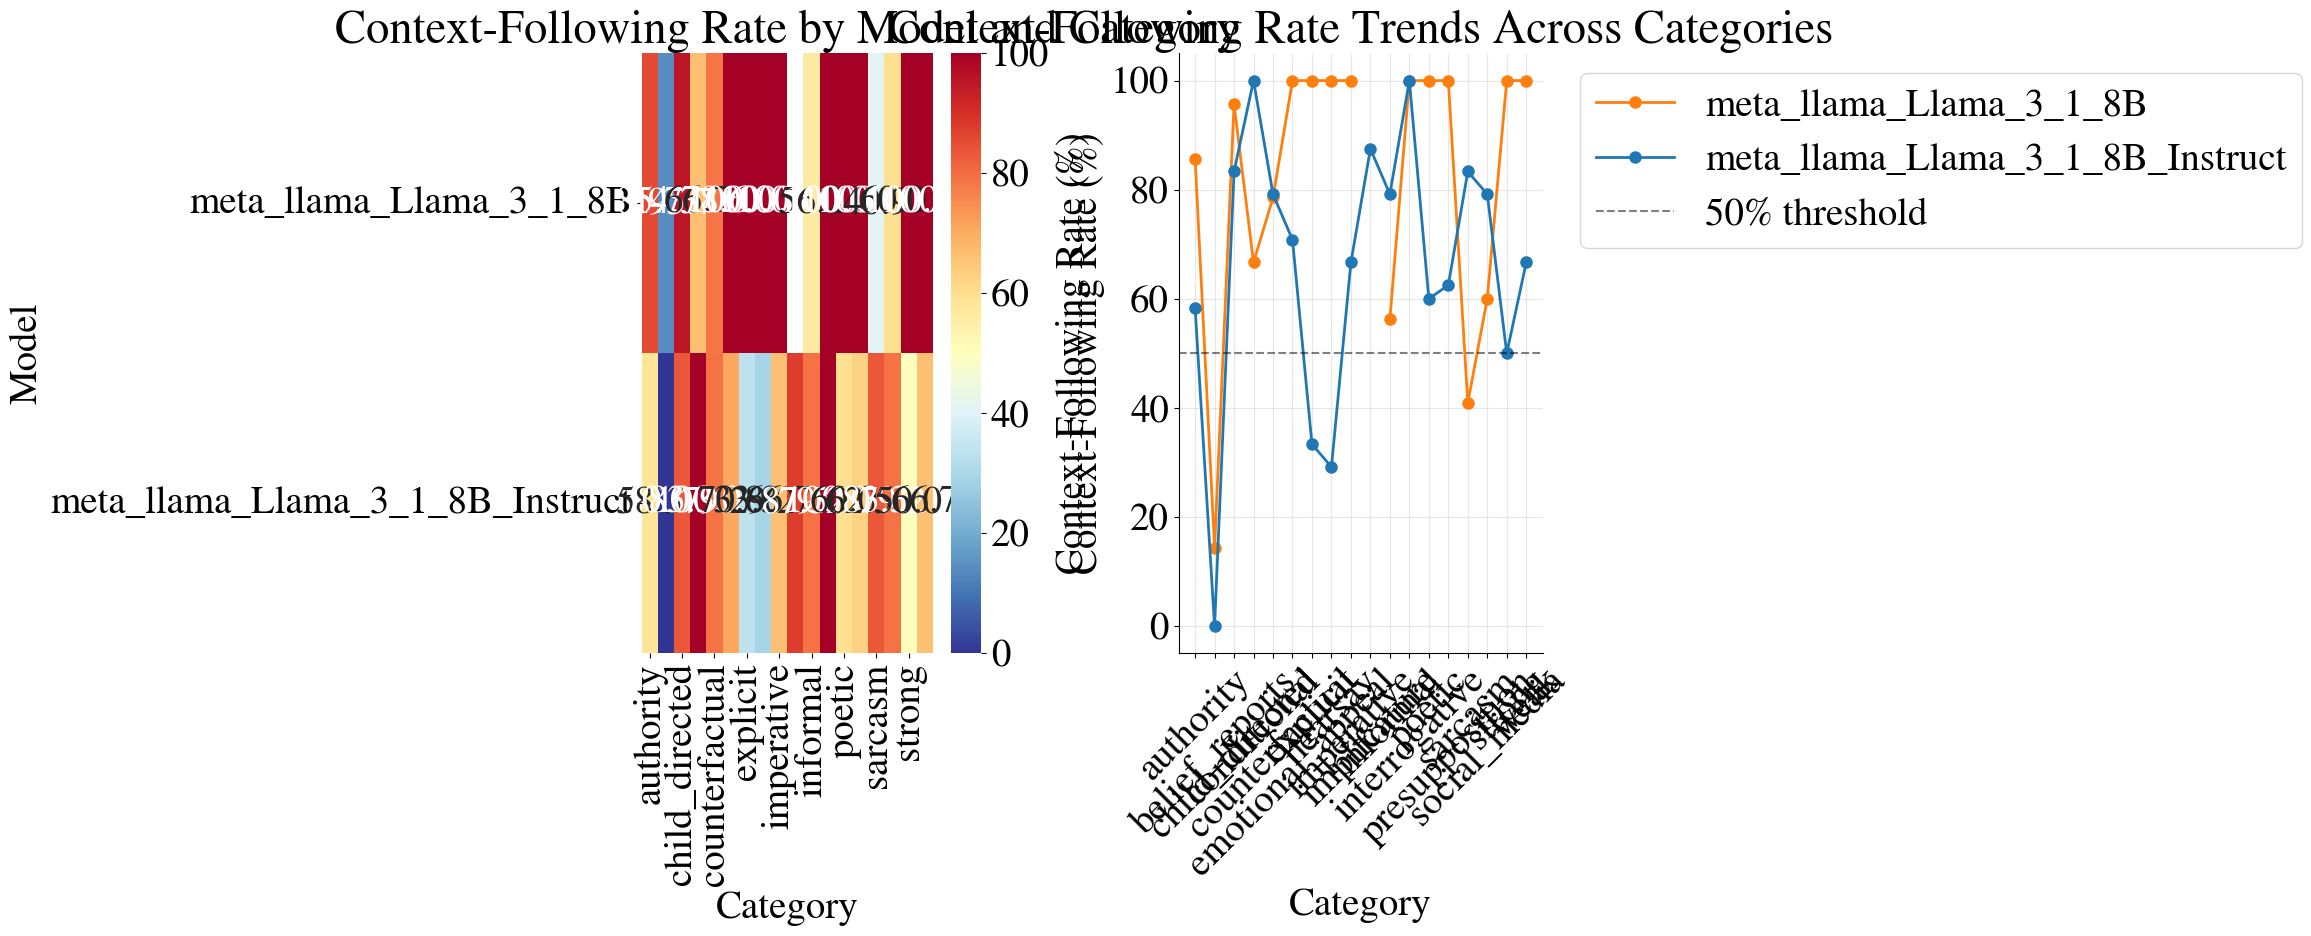


=== CATEGORY EFFECTIVENESS COMPARISON ===
Context-following rates by category and model:
                  meta_llama_Llama_3_1_8B  meta_llama_Llama_3_1_8B_Instruct
category                                                                   
authority                            85.7                              58.3
belief_reports                       14.3                               0.0
child_directed                       95.7                              83.3
conditional                          66.7                             100.0
counterfactual                       78.6                              79.2
emotional_appeal                    100.0                              70.8
explicit                            100.0                              33.3
hearsay                             100.0                              29.2
imperative                          100.0                              66.7
implicature                           NaN                              87.

In [5]:
if len(model_data) > 1:
    # Category effectiveness comparison
    categories = sorted(combined_df['category'].unique())
    
    # Calculate context-following rates by category for each model
    category_effectiveness = []
    
    for category in categories:
        category_data = {'category': category}
        for model_name, df in model_data.items():
            cat_df = df[df['category'] == category]
            memory_count = len(cat_df[cat_df['classification'] == 'memory'])
            context_count = len(cat_df[cat_df['classification'] == 'context'])
            total_clear = memory_count + context_count
            
            if total_clear > 0:
                context_rate = (context_count / total_clear) * 100
            else:
                context_rate = np.nan
            
            category_data[model_name] = context_rate
        
        category_effectiveness.append(category_data)
    
    effectiveness_df = pd.DataFrame(category_effectiveness).set_index('category')
    
    # Plot category effectiveness comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Heatmap of context-following rates
    sns.heatmap(effectiveness_df.T, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                center=50, ax=ax1, cbar_kws={'label': 'Context-Following Rate (%)'})
    ax1.set_title('Context-Following Rate by Model and Category')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Model')
    
    # Line plot showing category effectiveness trends
    for model_name in model_data.keys():
        if model_name in effectiveness_df.columns:
            color = MODEL_COLORS.get(model_name, '#gray')
            ax2.plot(effectiveness_df.index, effectiveness_df[model_name], 
                    marker='o', label=model_name, color=color, linewidth=2, markersize=8)
    
    ax2.set_title('Context-Following Rate Trends Across Categories')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Context-Following Rate (%)')
    ax2.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='50% threshold')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== CATEGORY EFFECTIVENESS COMPARISON ===")
    print("Context-following rates by category and model:")
    print(effectiveness_df.round(1))
else:
    print("Need at least 2 models for comparison.")

## Dimension-Level Analysis

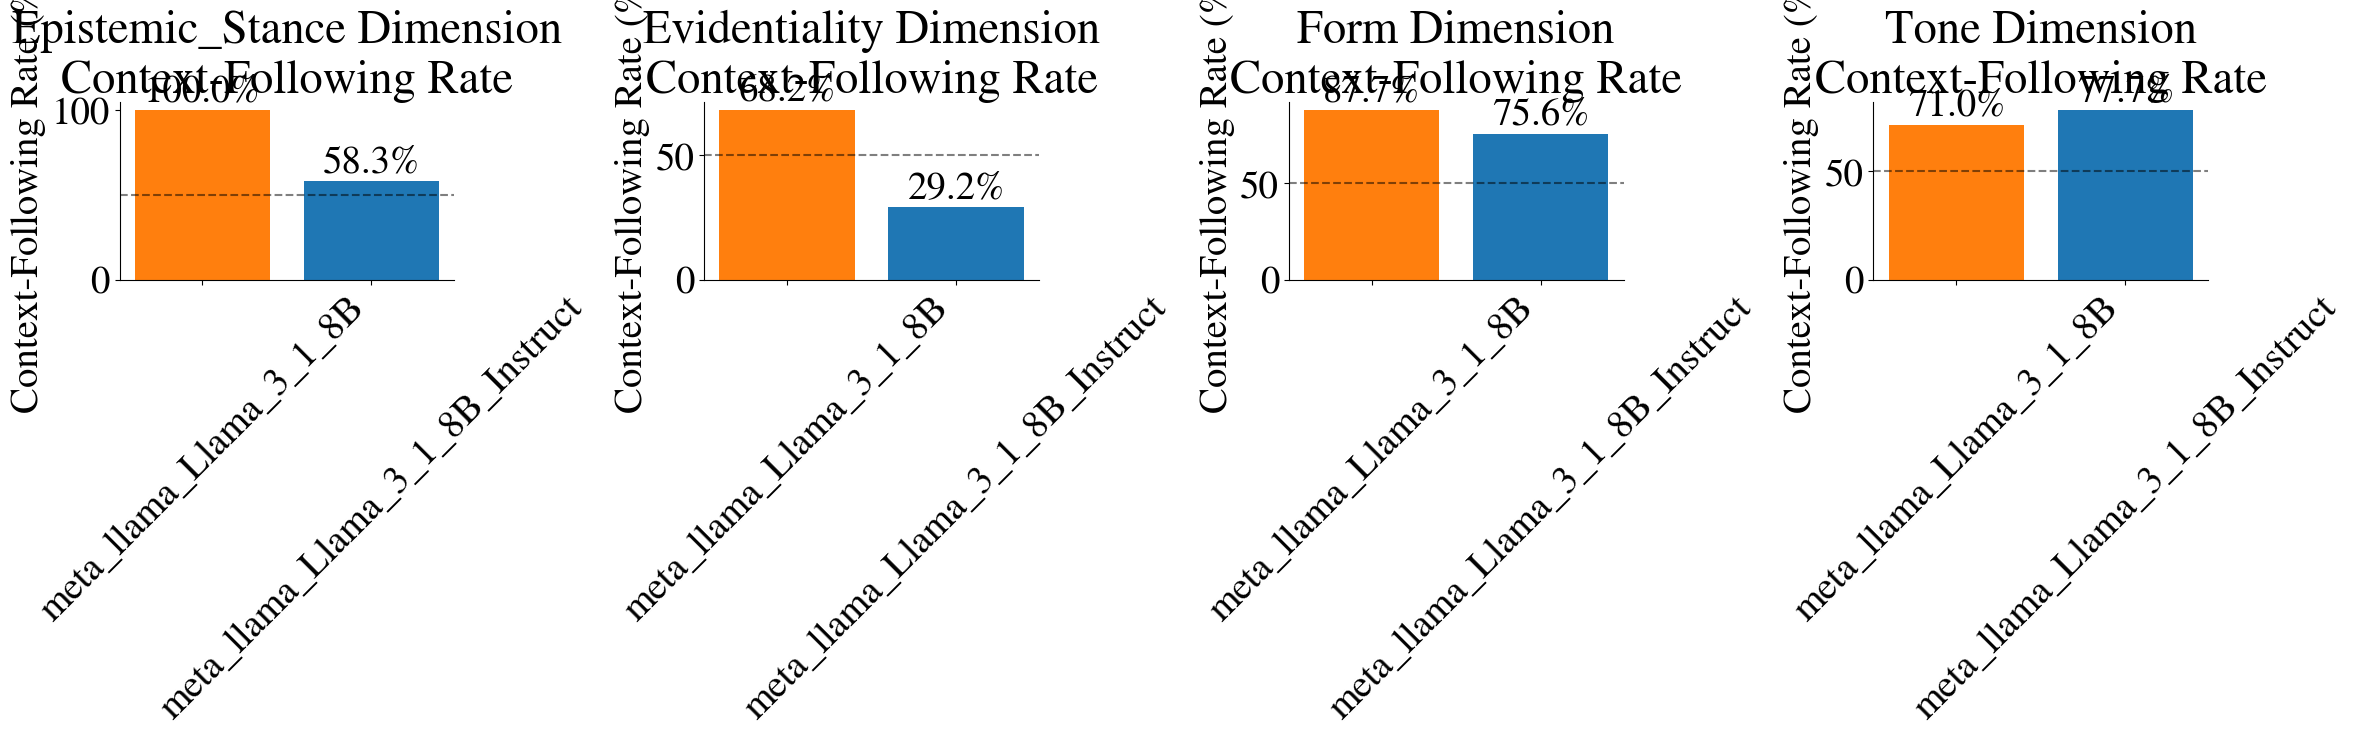


=== DIMENSION EFFECTIVENESS COMPARISON ===
Context-following rates by dimension and model:
                  meta_llama_Llama_3_1_8B  meta_llama_Llama_3_1_8B_Instruct
dimension                                                                  
epistemic_stance                    100.0                              58.3
evidentiality                        68.2                              29.2
form                                 87.7                              75.6
tone                                 71.0                              77.7


In [6]:
if len(model_data) > 1:
    # Dimension effectiveness comparison
    dimensions = sorted(combined_df['dimension'].unique())
    
    # Calculate context-following rates by dimension for each model
    dimension_effectiveness = []
    
    for dimension in dimensions:
        dimension_data = {'dimension': dimension}
        for model_name, df in model_data.items():
            dim_df = df[df['dimension'] == dimension]
            memory_count = len(dim_df[dim_df['classification'] == 'memory'])
            context_count = len(dim_df[dim_df['classification'] == 'context'])
            total_clear = memory_count + context_count
            
            if total_clear > 0:
                context_rate = (context_count / total_clear) * 100
            else:
                context_rate = np.nan
            
            dimension_data[model_name] = context_rate
        
        dimension_effectiveness.append(dimension_data)
    
    dimension_df = pd.DataFrame(dimension_effectiveness).set_index('dimension')
    
    # Plot dimension effectiveness comparison
    fig, axes = plt.subplots(1, len(dimensions), figsize=(6*len(dimensions), 8))
    if len(dimensions) == 1:
        axes = [axes]
    
    for i, dimension in enumerate(dimensions):
        dim_data = dimension_df.loc[dimension]
        model_names = dim_data.index
        values = dim_data.values
        colors = [MODEL_COLORS.get(name, '#gray') for name in model_names]
        
        bars = axes[i].bar(model_names, values, color=colors)
        axes[i].set_title(f'{dimension.title()} Dimension\nContext-Following Rate')
        axes[i].set_ylabel('Context-Following Rate (%)')
        axes[i].axhline(y=50, color='black', linestyle='--', alpha=0.5)
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar, val in zip(bars, values):
            if not np.isnan(val):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                           f'{val:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== DIMENSION EFFECTIVENESS COMPARISON ===")
    print("Context-following rates by dimension and model:")
    print(dimension_df.round(1))
else:
    print("Need at least 2 models for comparison.")

## Fact-Level Consistency Analysis

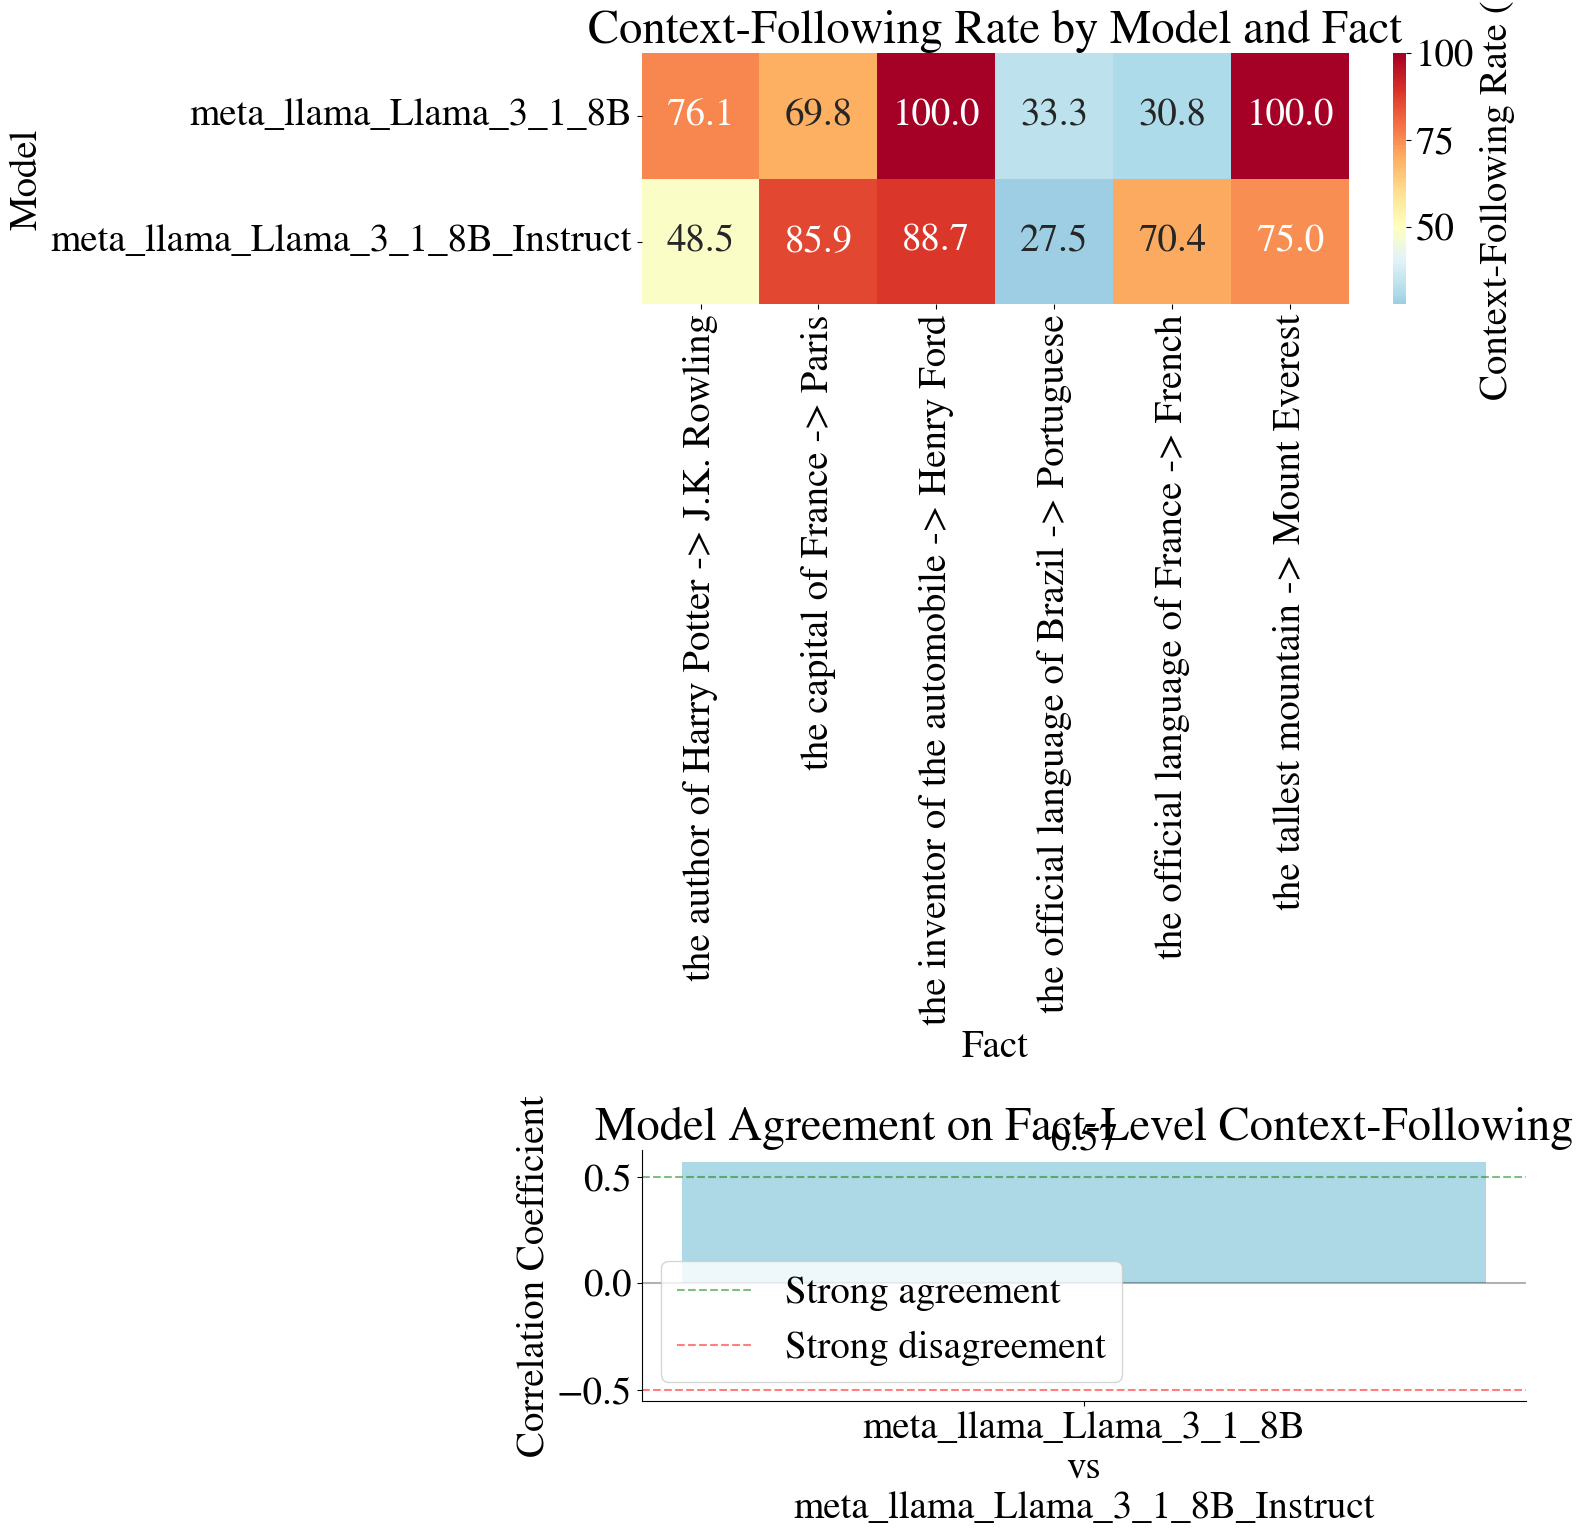


=== FACT-LEVEL CONSISTENCY ANALYSIS ===
Context-following rates by fact and model:
                                               meta_llama_Llama_3_1_8B  \
fact_id                                                                  
the author of Harry Potter -> J.K. Rowling                        76.1   
the capital of France -> Paris                                    69.8   
the inventor of the automobile -> Henry Ford                     100.0   
the official language of Brazil -> Portuguese                     33.3   
the official language of France -> French                         30.8   
the tallest mountain -> Mount Everest                            100.0   

                                               meta_llama_Llama_3_1_8B_Instruct  
fact_id                                                                          
the author of Harry Potter -> J.K. Rowling                                 48.5  
the capital of France -> Paris                                             85

In [7]:
if len(model_data) > 1:
    # Analyze consistency across facts
    facts = sorted(combined_df['fact_id'].unique())
    
    # Calculate context-following rates by fact for each model
    fact_consistency = []
    
    for fact in facts:
        fact_data = {'fact_id': fact}
        for model_name, df in model_data.items():
            fact_df = df[df['fact_id'] == fact]
            memory_count = len(fact_df[fact_df['classification'] == 'memory'])
            context_count = len(fact_df[fact_df['classification'] == 'context'])
            total_clear = memory_count + context_count
            
            if total_clear > 0:
                context_rate = (context_count / total_clear) * 100
            else:
                context_rate = np.nan
            
            fact_data[model_name] = context_rate
        
        fact_consistency.append(fact_data)
    
    fact_df = pd.DataFrame(fact_consistency).set_index('fact_id')
    
    # Plot fact-level consistency
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))
    
    # Heatmap of fact-level context-following rates
    sns.heatmap(fact_df.T, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                center=50, ax=ax1, cbar_kws={'label': 'Context-Following Rate (%)'})
    ax1.set_title('Context-Following Rate by Model and Fact')
    ax1.set_xlabel('Fact')
    ax1.set_ylabel('Model')
    
    # Model agreement analysis
    if len(model_data) >= 2:
        model_names = list(model_data.keys())
        correlations = []
        
        for i in range(len(model_names)):
            for j in range(i+1, len(model_names)):
                model1, model2 = model_names[i], model_names[j]
                
                # Get common facts
                common_facts = fact_df.dropna(subset=[model1, model2])
                if len(common_facts) > 1:
                    corr = common_facts[model1].corr(common_facts[model2])
                    correlations.append({
                        'model1': model1,
                        'model2': model2,
                        'correlation': corr,
                        'common_facts': len(common_facts)
                    })
        
        if correlations:
            corr_df = pd.DataFrame(correlations)
            
            # Plot correlations
            x_pos = range(len(corr_df))
            labels = [f"{row['model1']}\nvs\n{row['model2']}" for _, row in corr_df.iterrows()]
            
            bars = ax2.bar(x_pos, corr_df['correlation'], 
                          color=['lightblue' if c > 0.5 else 'lightcoral' for c in corr_df['correlation']])
            ax2.set_title('Model Agreement on Fact-Level Context-Following')
            ax2.set_ylabel('Correlation Coefficient')
            ax2.set_xticks(x_pos)
            ax2.set_xticklabels(labels, rotation=0)
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax2.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Strong agreement')
            ax2.axhline(y=-0.5, color='red', linestyle='--', alpha=0.5, label='Strong disagreement')
            ax2.legend()
            
            # Add value labels
            for bar, corr in zip(bars, corr_df['correlation']):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                        f'{corr:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== FACT-LEVEL CONSISTENCY ANALYSIS ===")
    print("Context-following rates by fact and model:")
    print(fact_df.round(1))
    
    if correlations:
        print("\n=== MODEL AGREEMENT ANALYSIS ===")
        for corr_data in correlations:
            print(f"{corr_data['model1']} vs {corr_data['model2']}: "
                  f"r = {corr_data['correlation']:.3f} "
                  f"(on {corr_data['common_facts']} common facts)")
else:
    print("Need at least 2 models for comparison.")

## Probability Distribution Analysis

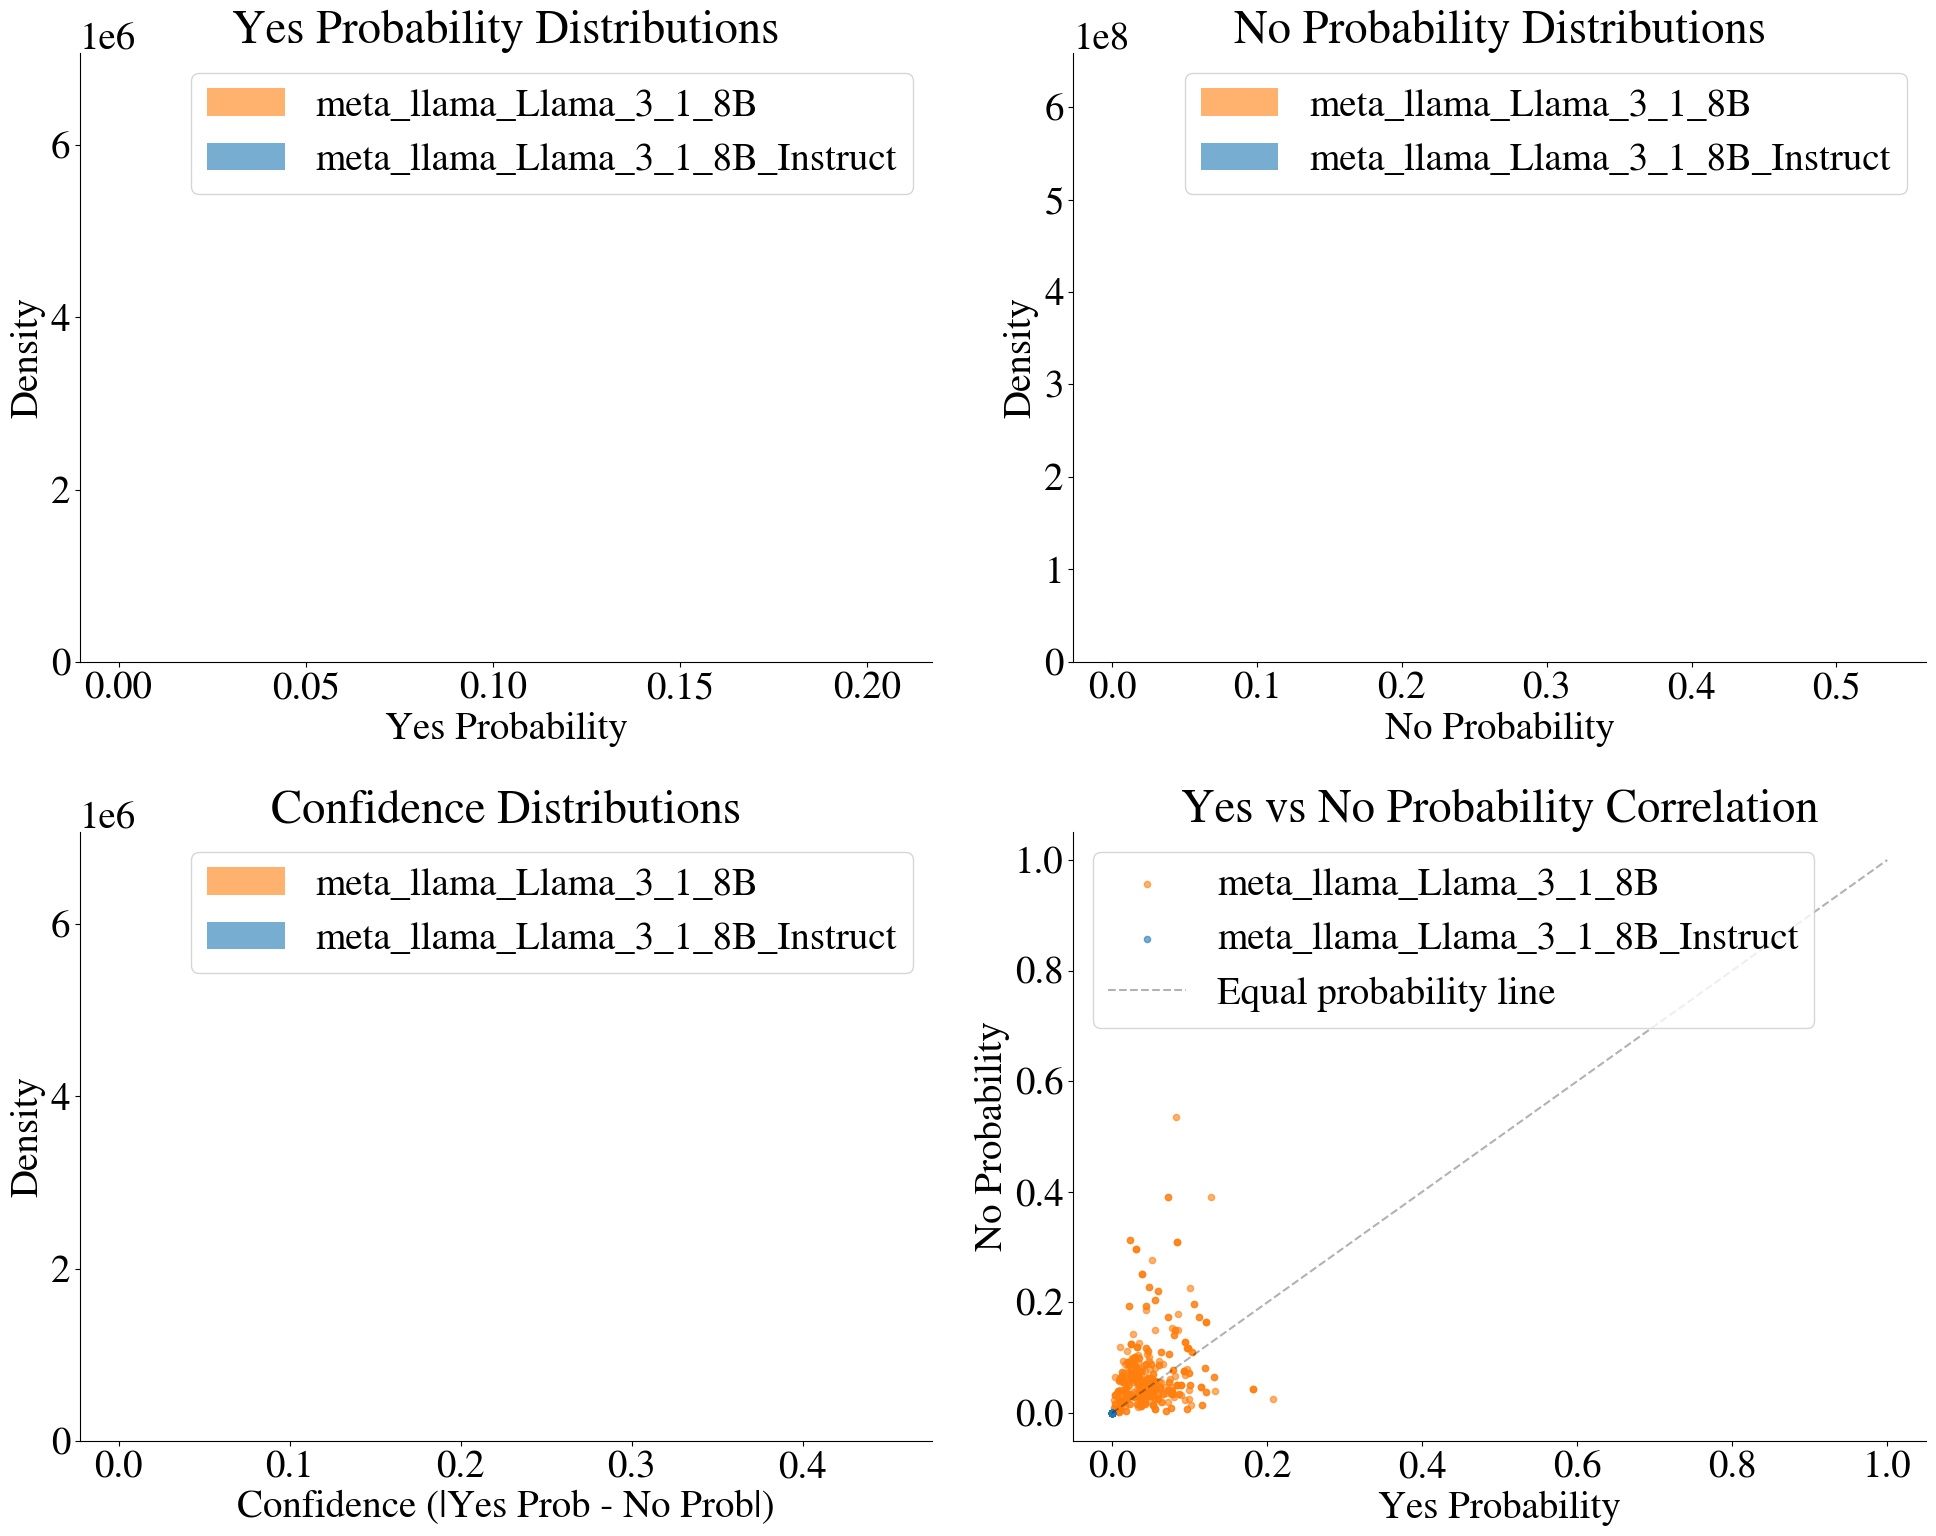


=== PROBABILITY STATISTICS COMPARISON ===
                                  avg_yes_prob  std_yes_prob  avg_no_prob  \
model                                                                       
meta_llama_Llama_3_1_8B                 0.0481        0.0331       0.0733   
meta_llama_Llama_3_1_8B_Instruct        0.0000        0.0000       0.0000   

                                  std_no_prob  avg_confidence  std_confidence  
model                                                                          
meta_llama_Llama_3_1_8B                0.0685          0.0491          0.0566  
meta_llama_Llama_3_1_8B_Instruct       0.0000          0.0000          0.0000  


In [8]:
if len(model_data) > 1:
    # Compare probability distributions across models
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Yes probability distributions
    for model_name, df in model_data.items():
        color = MODEL_COLORS.get(model_name, '#gray')
        axes[0,0].hist(df['yes_probability'], bins=30, alpha=0.6, 
                      label=model_name, color=color, density=True)
    axes[0,0].set_title('Yes Probability Distributions')
    axes[0,0].set_xlabel('Yes Probability')
    axes[0,0].set_ylabel('Density')
    axes[0,0].legend()
    
    # 2. No probability distributions
    for model_name, df in model_data.items():
        color = MODEL_COLORS.get(model_name, '#gray')
        axes[0,1].hist(df['no_probability'], bins=30, alpha=0.6, 
                      label=model_name, color=color, density=True)
    axes[0,1].set_title('No Probability Distributions')
    axes[0,1].set_xlabel('No Probability')
    axes[0,1].set_ylabel('Density')
    axes[0,1].legend()
    
    # 3. Confidence distributions
    for model_name, df in model_data.items():
        color = MODEL_COLORS.get(model_name, '#gray')
        axes[1,0].hist(df['confidence'], bins=30, alpha=0.6, 
                      label=model_name, color=color, density=True)
    axes[1,0].set_title('Confidence Distributions')
    axes[1,0].set_xlabel('Confidence (|Yes Prob - No Prob|)')
    axes[1,0].set_ylabel('Density')
    axes[1,0].legend()
    
    # 4. Yes vs No probability scatter
    for model_name, df in model_data.items():
        color = MODEL_COLORS.get(model_name, '#gray')
        axes[1,1].scatter(df['yes_probability'], df['no_probability'], 
                         alpha=0.6, label=model_name, color=color, s=20)
    axes[1,1].set_title('Yes vs No Probability Correlation')
    axes[1,1].set_xlabel('Yes Probability')
    axes[1,1].set_ylabel('No Probability')
    axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Equal probability line')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\n=== PROBABILITY STATISTICS COMPARISON ===")
    prob_stats = []
    for model_name, df in model_data.items():
        stats = {
            'model': model_name,
            'avg_yes_prob': df['yes_probability'].mean(),
            'std_yes_prob': df['yes_probability'].std(),
            'avg_no_prob': df['no_probability'].mean(),
            'std_no_prob': df['no_probability'].std(),
            'avg_confidence': df['confidence'].mean(),
            'std_confidence': df['confidence'].std()
        }
        prob_stats.append(stats)
    
    prob_stats_df = pd.DataFrame(prob_stats).set_index('model')
    print(prob_stats_df.round(4))
else:
    print("Need at least 2 models for comparison.")

## Advanced Analysis: Category × Dimension Interactions

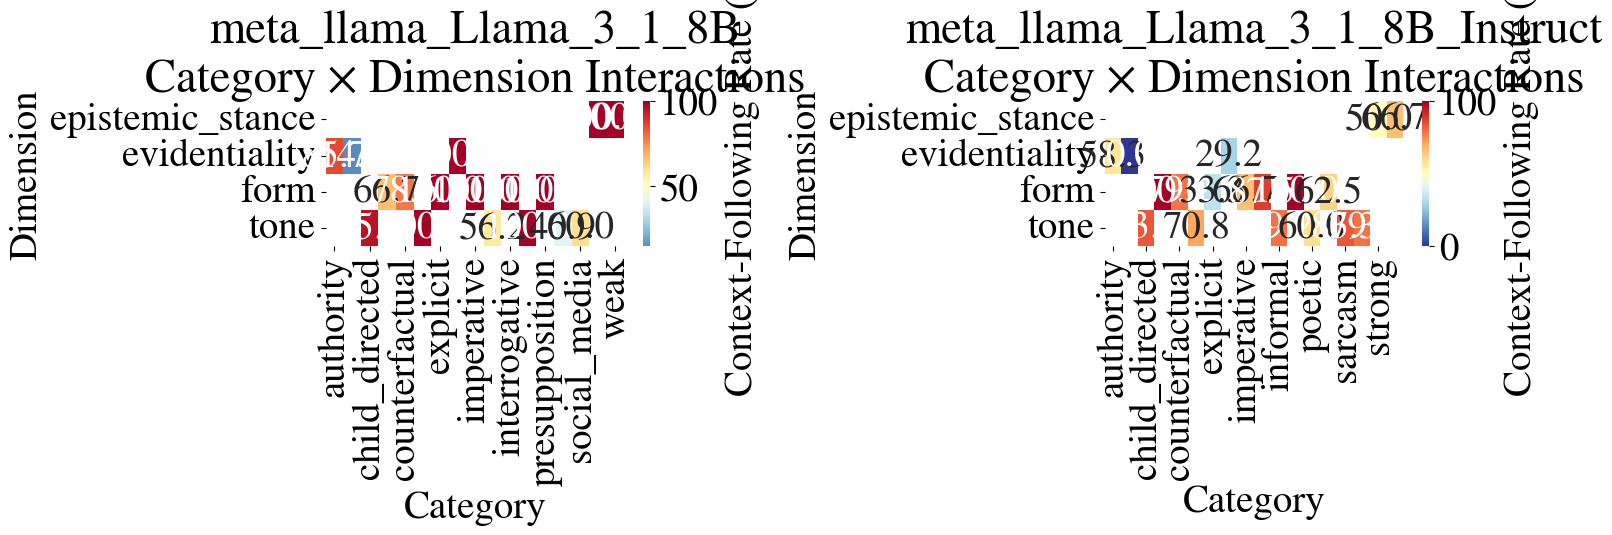


=== CATEGORY × DIMENSION INTERACTION ANALYSIS ===

meta_llama_Llama_3_1_8B:
category          authority  belief_reports  child_directed  conditional  \
dimension                                                                  
epistemic_stance        NaN             NaN             NaN          NaN   
evidentiality          85.7            14.3             NaN          NaN   
form                    NaN             NaN             NaN         66.7   
tone                    NaN             NaN            95.7          NaN   

category          counterfactual  emotional_appeal  explicit  hearsay  \
dimension                                                               
epistemic_stance             NaN               NaN       NaN      NaN   
evidentiality                NaN               NaN       NaN    100.0   
form                        78.6               NaN     100.0      NaN   
tone                         NaN             100.0       NaN      NaN   

category          imperativ

In [9]:
if len(model_data) > 1:
    # Analyze how models perform on category-dimension combinations
    category_dimension_analysis = []
    
    for model_name, df in model_data.items():
        for category in df['category'].unique():
            for dimension in df['dimension'].unique():
                subset = df[(df['category'] == category) & (df['dimension'] == dimension)]
                
                if len(subset) > 0:
                    memory_count = len(subset[subset['classification'] == 'memory'])
                    context_count = len(subset[subset['classification'] == 'context'])
                    total_clear = memory_count + context_count
                    
                    if total_clear > 0:
                        context_rate = (context_count / total_clear) * 100
                    else:
                        context_rate = np.nan
                    
                    category_dimension_analysis.append({
                        'model': model_name,
                        'category': category,
                        'dimension': dimension,
                        'context_rate': context_rate,
                        'total_examples': len(subset),
                        'clear_examples': total_clear
                    })
    
    cat_dim_df = pd.DataFrame(category_dimension_analysis)
    
    if len(cat_dim_df) > 0:
        # Create pivot tables for each model
        models = cat_dim_df['model'].unique()
        n_models = len(models)
        
        fig, axes = plt.subplots(1, n_models, figsize=(8*n_models, 6))
        if n_models == 1:
            axes = [axes]
        
        for i, model in enumerate(models):
            model_data = cat_dim_df[cat_dim_df['model'] == model]
            pivot = model_data.pivot_table(values='context_rate', 
                                         index='dimension', 
                                         columns='category', 
                                         aggfunc='mean')
            
            sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                       center=50, ax=axes[i], 
                       cbar_kws={'label': 'Context-Following Rate (%)'})
            axes[i].set_title(f'{model}\nCategory × Dimension Interactions')
            axes[i].set_xlabel('Category')
            axes[i].set_ylabel('Dimension')
        
        plt.tight_layout()
        plt.show()
        
        print("\n=== CATEGORY × DIMENSION INTERACTION ANALYSIS ===")
        for model in models:
            print(f"\n{model}:")
            model_data = cat_dim_df[cat_dim_df['model'] == model]
            pivot = model_data.pivot_table(values='context_rate', 
                                         index='dimension', 
                                         columns='category', 
                                         aggfunc='mean')
            print(pivot.round(1))
    else:
        print("No category-dimension interaction data found.")
else:
    print("Need at least 2 models for comparison.")

## Model Ranking and Summary

In [10]:
if len(model_data) > 1:
    # Create comprehensive model ranking
    model_rankings = []
    
    for model_name, df in model_data.items():
        # Calculate key metrics
        memory_count = len(df[df['classification'] == 'memory'])
        context_count = len(df[df['classification'] == 'context'])
        error_count = len(df[df['classification'] == 'error'])
        other_count = len(df[df['classification'] == 'other'])
        total = len(df)
        
        # Context-following rate (higher is more susceptible to context)
        total_clear = memory_count + context_count
        context_rate = (context_count / total_clear * 100) if total_clear > 0 else 0
        
        # Error rate (lower is better)
        error_rate = error_count / total * 100
        
        # Average confidence (higher suggests more certainty)
        avg_confidence = df['confidence'].mean()
        
        # Consistency across categories (lower std dev is more consistent)
        category_rates = []
        for category in df['category'].unique():
            cat_df = df[df['category'] == category]
            cat_memory = len(cat_df[cat_df['classification'] == 'memory'])
            cat_context = len(cat_df[cat_df['classification'] == 'context'])
            cat_total_clear = cat_memory + cat_context
            if cat_total_clear > 0:
                cat_rate = cat_context / cat_total_clear * 100
                category_rates.append(cat_rate)
        
        consistency = np.std(category_rates) if category_rates else 0
        
        model_rankings.append({
            'model': model_name,
            'context_following_rate': context_rate,
            'error_rate': error_rate,
            'avg_confidence': avg_confidence,
            'category_consistency': consistency,
            'total_examples': total,
            'memory_pct': memory_count / total * 100,
            'context_pct': context_count / total * 100,
            'other_pct': other_count / total * 100
        })
    
    ranking_df = pd.DataFrame(model_rankings).set_index('model')
    
    # Create comprehensive summary visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Context-following vs Error rate
    for i, (model_name, row) in enumerate(ranking_df.iterrows()):
        color = MODEL_COLORS.get(model_name, '#gray')
        axes[0,0].scatter(row['context_following_rate'], row['error_rate'], 
                         s=200, color=color, alpha=0.7, label=model_name)
    axes[0,0].set_xlabel('Context-Following Rate (%)')
    axes[0,0].set_ylabel('Error Rate (%)')
    axes[0,0].set_title('Context-Following vs Error Rate')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Confidence vs Consistency
    for i, (model_name, row) in enumerate(ranking_df.iterrows()):
        color = MODEL_COLORS.get(model_name, '#gray')
        axes[0,1].scatter(row['avg_confidence'], row['category_consistency'], 
                         s=200, color=color, alpha=0.7, label=model_name)
    axes[0,1].set_xlabel('Average Confidence')
    axes[0,1].set_ylabel('Category Inconsistency (Std Dev)')
    axes[0,1].set_title('Confidence vs Category Consistency')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Model comparison radar chart (if we have 2+ models)
    if len(model_data) >= 2:
        # Normalize metrics for radar chart (0-100 scale)
        metrics = ['context_following_rate', 'avg_confidence', 'category_consistency', 'error_rate']
        normalized_df = ranking_df[metrics].copy()
        
        # Normalize each metric to 0-100 scale
        for metric in metrics:
            if metric == 'error_rate' or metric == 'category_consistency':  # Lower is better
                normalized_df[metric] = 100 - ((normalized_df[metric] - normalized_df[metric].min()) / 
                                               (normalized_df[metric].max() - normalized_df[metric].min()) * 100)
            else:  # Higher is better
                normalized_df[metric] = ((normalized_df[metric] - normalized_df[metric].min()) / 
                                        (normalized_df[metric].max() - normalized_df[metric].min()) * 100)
        
        # Fill NaN with 50 (neutral)
        normalized_df = normalized_df.fillna(50)
        
        # Create radar chart
        angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        
        ax3 = plt.subplot(2, 2, 3, projection='polar')
        
        for model_name in normalized_df.index:
            values = normalized_df.loc[model_name].tolist()
            values += values[:1]  # Complete the circle
            color = MODEL_COLORS.get(model_name, '#gray')
            ax3.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
            ax3.fill(angles, values, alpha=0.25, color=color)
        
        ax3.set_xticks(angles[:-1])
        ax3.set_xticklabels(['Context\nFollowing', 'Confidence', 'Consistency', 'Low Error'])
        ax3.set_ylim(0, 100)
        ax3.set_title('Model Performance Radar Chart')
        ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    
    # 4. Overall ranking bar chart
    # Calculate composite score (this is subjective and can be adjusted)
    ranking_df['composite_score'] = (
        ranking_df['context_following_rate'] * 0.4 +  # 40% weight
        (100 - ranking_df['error_rate']) * 0.3 +      # 30% weight (inverted)
        ranking_df['avg_confidence'] * 100 * 0.2 +    # 20% weight
        (100 - ranking_df['category_consistency']) * 0.1  # 10% weight (inverted)
    )
    
    ranking_sorted = ranking_df.sort_values('composite_score', ascending=False)
    
    colors = [MODEL_COLORS.get(name, '#gray') for name in ranking_sorted.index]
    bars = axes[1,1].bar(range(len(ranking_sorted)), ranking_sorted['composite_score'], color=colors)
    axes[1,1].set_xticks(range(len(ranking_sorted)))
    axes[1,1].set_xticklabels(ranking_sorted.index, rotation=45)
    axes[1,1].set_ylabel('Composite Score')
    axes[1,1].set_title('Overall Model Ranking')
    
    # Add value labels
    for bar, score in zip(bars, ranking_sorted['composite_score']):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                      f'{score:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== COMPREHENSIVE MODEL RANKING ===")
    print("\nDetailed Metrics:")
    print(ranking_df.round(2))
    
    print("\n=== FINAL RANKING (by composite score) ===")
    for i, (model_name, row) in enumerate(ranking_sorted.iterrows(), 1):
        print(f"\n{i}. {model_name} (Score: {row['composite_score']:.1f})")
        print(f"   - Context-following rate: {row['context_following_rate']:.1f}%")
        print(f"   - Error rate: {row['error_rate']:.1f}%")
        print(f"   - Average confidence: {row['avg_confidence']:.3f}")
        print(f"   - Category consistency: {row['category_consistency']:.1f} (std dev)")
        print(f"   - Total examples: {row['total_examples']}")
else:
    print("Need at least 2 models for ranking.")

KeyError: 'classification'

## Key Insights and Recommendations

In [ ]:
if len(model_data) > 1:
    print("=== KEY INSIGHTS AND RECOMMENDATIONS ===")
    
    # Best and worst performers
    best_context_follower = ranking_df['context_following_rate'].idxmax()
    worst_context_follower = ranking_df['context_following_rate'].idxmin()
    lowest_error = ranking_df['error_rate'].idxmin()
    highest_confidence = ranking_df['avg_confidence'].idxmax()
    most_consistent = ranking_df['category_consistency'].idxmin()
    
    print(f"\n1. CONTEXT SUSCEPTIBILITY:")
    print(f"   - Most susceptible to context: {best_context_follower} ({ranking_df.loc[best_context_follower, 'context_following_rate']:.1f}%)")
    print(f"   - Most resistant to context: {worst_context_follower} ({ranking_df.loc[worst_context_follower, 'context_following_rate']:.1f}%)")
    
    print(f"\n2. RELIABILITY:")
    print(f"   - Lowest error rate: {lowest_error} ({ranking_df.loc[lowest_error, 'error_rate']:.1f}%)")
    print(f"   - Highest confidence: {highest_confidence} ({ranking_df.loc[highest_confidence, 'avg_confidence']:.3f})")
    print(f"   - Most consistent across categories: {most_consistent} (std dev: {ranking_df.loc[most_consistent, 'category_consistency']:.1f})")
    
    print(f"\n3. CATEGORY INSIGHTS:")
    if 'effectiveness_df' in locals():
        # Find most and least effective categories
        category_means = effectiveness_df.mean(axis=1).sort_values(ascending=False)
        most_effective_cat = category_means.index[0] if len(category_means) > 0 else "N/A"
        least_effective_cat = category_means.index[-1] if len(category_means) > 0 else "N/A"
        
        print(f"   - Most effective category (highest context-following): {most_effective_cat}")
        print(f"   - Least effective category (lowest context-following): {least_effective_cat}")
    
    print(f"\n4. RECOMMENDATIONS:")
    print(f"   - For testing context susceptibility: Use {best_context_follower}")
    print(f"   - For robust performance: Use {lowest_error}")
    print(f"   - For consistent behavior: Use {most_consistent}")
    
    # Model-specific insights
    print(f"\n5. MODEL-SPECIFIC INSIGHTS:")
    for model_name, row in ranking_df.iterrows():
        print(f"\n   {model_name}:")
        
        # Context sensitivity
        if row['context_following_rate'] > 60:
            print(f"     + Highly susceptible to contextual assertions")
        elif row['context_following_rate'] < 40:
            print(f"     + Resistant to contextual manipulation")
        else:
            print(f"     + Moderate context sensitivity")
        
        # Reliability
        if row['error_rate'] < 5:
            print(f"     + Very reliable (low error rate)")
        elif row['error_rate'] > 15:
            print(f"     - High error rate, may need improvement")
        
        # Confidence
        if row['avg_confidence'] > 0.5:
            print(f"     + High confidence in responses")
        elif row['avg_confidence'] < 0.1:
            print(f"     - Low confidence, uncertain responses")
        
        # Consistency
        if row['category_consistency'] < 10:
            print(f"     + Consistent across different categories")
        elif row['category_consistency'] > 25:
            print(f"     - Inconsistent behavior across categories")
else:
    print("Need multiple models for comprehensive insights.")

## Export Results

In [ ]:
# Save comparison results
if len(model_data) > 1:
    output_dir = Path('comparison_results')
    output_dir.mkdir(exist_ok=True)
    
    # Save detailed comparison data
    comparison_data = {
        'model_rankings': ranking_df.to_dict('index'),
        'category_effectiveness': effectiveness_df.to_dict('index') if 'effectiveness_df' in locals() else {},
        'dimension_effectiveness': dimension_df.to_dict('index') if 'dimension_df' in locals() else {},
        'fact_consistency': fact_df.to_dict('index') if 'fact_df' in locals() else {},
        'probability_statistics': prob_stats_df.to_dict('index') if 'prob_stats_df' in locals() else {},
        'model_correlations': correlations if 'correlations' in locals() else [],
        'summary': {
            'total_models': len(model_data),
            'best_context_follower': ranking_df['context_following_rate'].idxmax(),
            'most_reliable': ranking_df['error_rate'].idxmin(),
            'most_confident': ranking_df['avg_confidence'].idxmax(),
            'most_consistent': ranking_df['category_consistency'].idxmin()
        }
    }
    
    # Save to JSON
    with open(output_dir / 'model_comparison_results.json', 'w') as f:
        json.dump(comparison_data, f, indent=2, default=str)
    
    # Save CSV files
    ranking_df.to_csv(output_dir / 'model_rankings.csv')
    if 'effectiveness_df' in locals():
        effectiveness_df.to_csv(output_dir / 'category_effectiveness.csv')
    if 'dimension_df' in locals():
        dimension_df.to_csv(output_dir / 'dimension_effectiveness.csv')
    
    print(f"\nComparison results saved to {output_dir}/")
    print(f"Files created:")
    print(f"  - model_comparison_results.json (comprehensive results)")
    print(f"  - model_rankings.csv (model performance metrics)")
    print(f"  - category_effectiveness.csv (category analysis)")
    print(f"  - dimension_effectiveness.csv (dimension analysis)")
else:
    print("Need multiple models to save comparison results.")